# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Column summary
| Variable | Definition                                 | Key                                            | int_value                                      |
|----------|--------------------------------------------|------------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |                                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |                                                |
| sex      | Sex                                        |                                                | 0 = male, 1 = female                           |
| Age      | Age in years                               |                                                |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |                                                |
| ticket   | Ticket number                              |                                                |                                                |
| fare     | Passenger fare                             |                                                |                                                |
| cabin    | Cabin number                               |                                                |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | 0 = Cherbourg, 1 = Queenstown, 2 = Southampton |

# Load the data

In [2]:
# Load the dataset
test_data = pd.read_csv("../data/test.csv")
train_data = pd.read_csv("../data/train.csv")

print("Number of passengers in train data: ", len(train_data))
train_data.head(5)

Number of passengers in train data:  891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data histograms

Text(0.5, 1.0, 'Embarked')

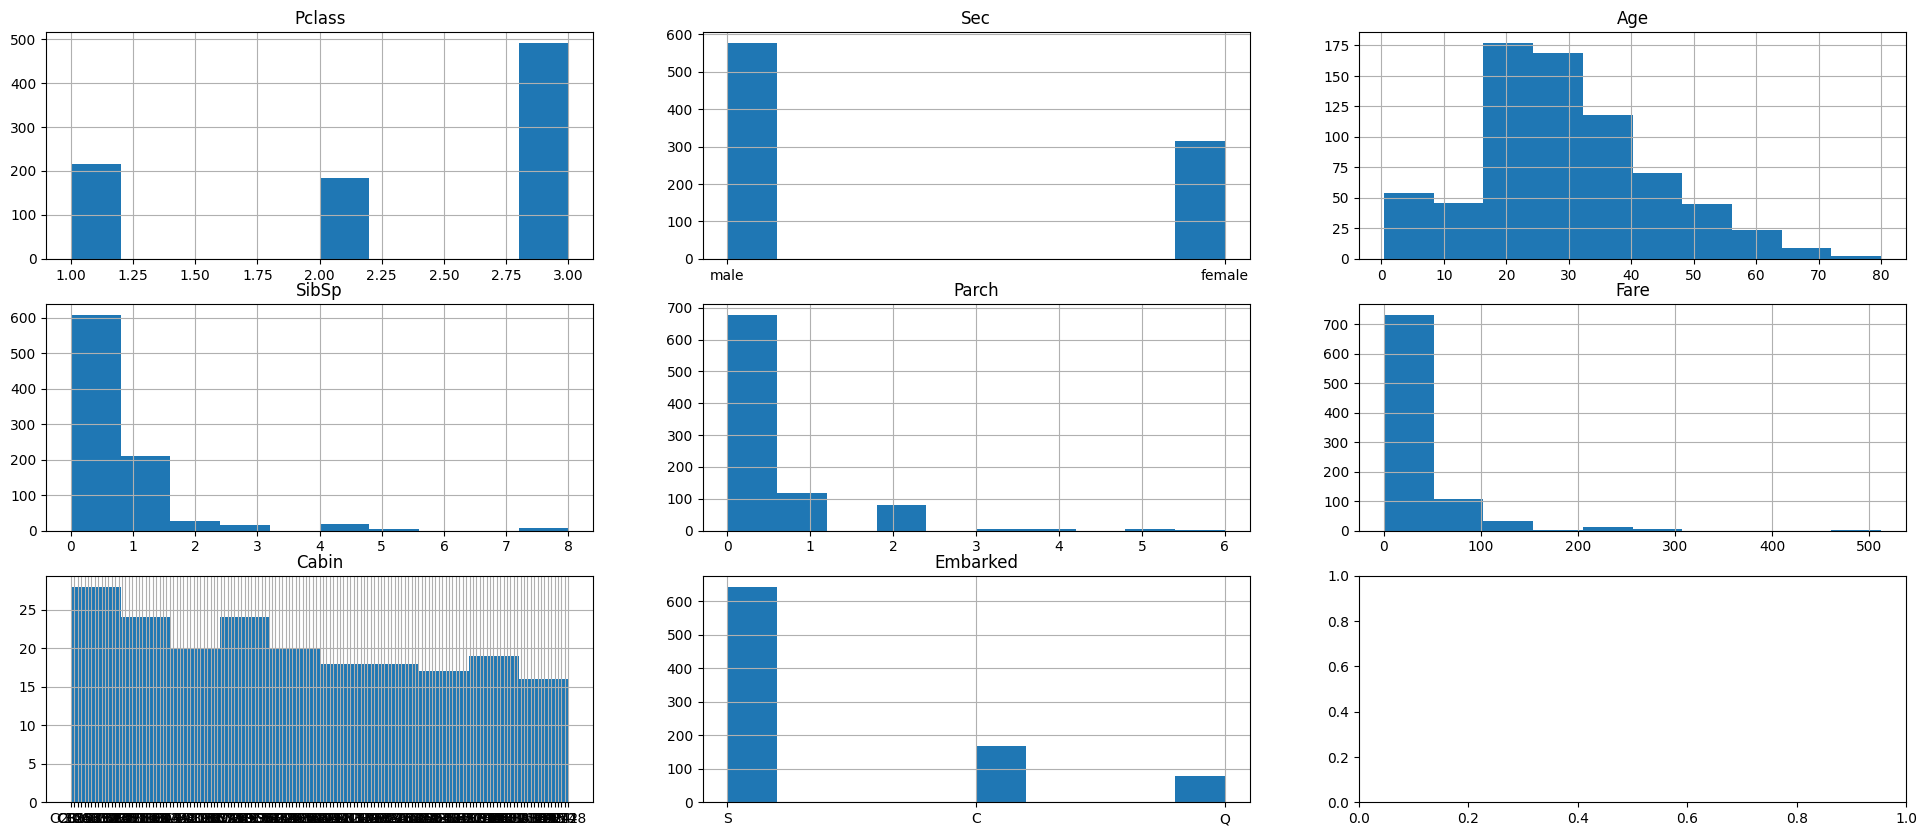

In [3]:
fig, axis = plt.subplots(3,3, figsize=(24,10))
train_data["Pclass"].hist(ax = axis[0][0])
axis[0][0].set_title("Pclass")

train_data["Sex"].hist(ax = axis[0][1])
axis[0][1].set_title("Sec")

train_data["Age"].hist(ax = axis[0][2])
axis[0][2].set_title("Age")

train_data["SibSp"].hist(ax = axis[1][0])
axis[1][0].set_title("SibSp")

train_data["Parch"].hist(ax = axis[1][1])
axis[1][1].set_title("Parch")

train_data["Fare"].hist(ax = axis[1][2])
axis[1][2].set_title("Fare")

train_data["Cabin"].hist(ax = axis[2][0])
axis[2][0].set_title("Cabin")

train_data["Embarked"].hist(ax = axis[2][1])
axis[2][1].set_title("Embarked")


# Discover bad records

In [4]:
# NAN records
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64